#### Training a Deep Neural Network with Time Series Data

In this lab, you will build upon the previous exercise and add more dense layers to your network. You will also look at a technique to tune the model's learning rate to make the weights converge faster. This is a useful tip so you can avoid guessing the learning rate before training.

The initial steps will be identical to the previous lab so you can run the next cells until the `Build the Model` section. That's where the discussions begin.

#### Imports

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#### Utilities

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    
    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

#### Generate the Synthetic Data

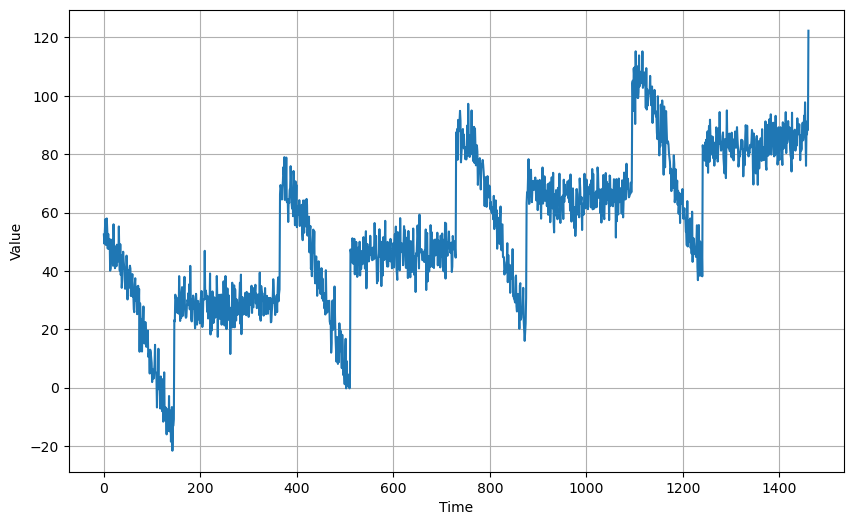

In [4]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

#### Split the Dataset

In [6]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

#### Prepare Features and Labels

In [7]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to average
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size)
    
    # Optimize the dataset for training
    dataset = dataset.cache().prefetch(1)
    
    return dataset

In [9]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

#### Build the Model

You will use three dense layers. As expected, the number of trainable parameters will increase and the model summary shows that it is more than tenfold of the previous lab.

In [8]:
# build the model
model_baseline = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,)),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1),
])

# print the model summary
model_baseline.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 331 (1.29 KB)

 Trainable params: 331 (1.29 KB)

 Non-trainable params: 0 (0.00 B)

#### Train the Model

In [9]:
# Set the training parameters
model_baseline.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

In [10]:
# Train the model
model_baseline.fit(dataset,epochs=100)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 2531.7747
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 161.7514
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 68.0535
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 61.9467
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - loss: 59.7188
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 58.0312
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - loss: 56.6734
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - loss: 55.5716
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - loss: 54.6522
Epoch 10/100


2024-12-18 16:56:49.748368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:49.778181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:49.802926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:49.828202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:49.851930: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:49.877005: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - loss: 53.9040
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - loss: 53.2378
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 52.6132
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - loss: 52.0520
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - loss: 51.5502
Epoch 15/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 51.1019
Epoch 16/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 50.6866
Epoch 17/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 50.2915
Epoch 18/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32.0470

2024-12-18 16:56:49.975790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:49.999549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:50.023929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:50.046988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:50.070796: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:50.096490: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 49.9262
Epoch 19/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - loss: 49.5970
Epoch 20/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 49.2785
Epoch 21/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - loss: 48.9872
Epoch 22/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - loss: 48.7253
Epoch 23/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 48.4885
Epoch 24/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 48.2667
Epoch 25/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 32.4252

2024-12-18 16:56:50.178086: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:50.207183: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:50.267610: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:50.294597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:50.318433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:50.345011: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - loss: 48.0423
Epoch 26/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - loss: 47.8175
Epoch 27/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - loss: 47.6085
Epoch 28/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 47.4388
Epoch 29/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - loss: 47.2823
Epoch 30/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 47.1351
Epoch 31/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 46.9872
Epoch 32/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - loss: 46.8225
Epoch 33/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33.0783

2024-12-18 16:56:50.398213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:50.425787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:50.449761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:50.473726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:50.497540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:50.523134: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - loss: 46.6386
Epoch 34/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - loss: 46.4685
Epoch 35/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - loss: 46.3416
Epoch 36/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - loss: 46.2330
Epoch 37/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 46.1244
Epoch 38/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 46.0251
Epoch 39/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - loss: 45.9262
Epoch 40/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33.9835

2024-12-18 16:56:50.602861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:50.634718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:50.665030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:50.694869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:50.733716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:50.763049: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 45.8296
Epoch 41/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 45.7311
Epoch 42/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 45.6327
Epoch 43/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 45.5367
Epoch 44/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 45.4441
Epoch 45/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - loss: 45.3519
Epoch 46/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 33.9304

2024-12-18 16:56:50.859807: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:50.895248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:50.930082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:50.964356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:50.999470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:51.032275: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 45.2623
Epoch 47/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 45.1754
Epoch 48/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 45.0827
Epoch 49/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 44.9930
Epoch 50/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - loss: 44.9066
Epoch 51/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 44.8203
Epoch 52/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - loss: 44.7273
Epoch 53/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33.5217

2024-12-18 16:56:51.066567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:51.102015: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:51.133085: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:51.162263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:51.191289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:51.219031: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 44.6377
Epoch 54/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 44.5572
Epoch 55/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 44.4792
Epoch 56/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - loss: 44.4057
Epoch 57/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - loss: 44.3339
Epoch 58/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 44.2640
Epoch 59/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 44.1947
Epoch 60/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33.3009

2024-12-18 16:56:51.280360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:51.313516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:51.343372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:51.370415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:51.395131: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:51.419991: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 44.1258
Epoch 61/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: 44.0570
Epoch 62/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 43.9915
Epoch 63/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - loss: 43.9275
Epoch 64/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - loss: 43.8624
Epoch 65/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - loss: 43.7972
Epoch 66/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - loss: 43.7328
Epoch 67/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - loss: 43.6761


2024-12-18 16:56:51.512904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:51.542805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:51.568431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:51.596948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:51.623041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:51.652913: W tensorflow/core/framework/local_rendezvous.cc:404]

Epoch 68/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 43.6145
Epoch 69/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - loss: 43.5553
Epoch 70/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 43.4955
Epoch 71/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 43.4360
Epoch 72/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - loss: 43.3781
Epoch 73/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 43.3207
Epoch 74/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 43.2646
Epoch 75/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 43.2149
Epoch 76/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32.7611

2024-12-18 16:56:51.742738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:51.769729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:51.795978: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:51.820881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:51.848645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:51.878330: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - loss: 43.1563
Epoch 77/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 43.1020
Epoch 78/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 43.0418
Epoch 79/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 42.9885
Epoch 80/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 42.9301
Epoch 81/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - loss: 42.8751
Epoch 82/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32.4900

2024-12-18 16:56:51.964311: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:51.991954: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:52.016792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:52.077463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:52.112958: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:52.142850: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - loss: 42.8267
Epoch 83/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 42.7757
Epoch 84/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - loss: 42.7190
Epoch 85/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - loss: 42.6665
Epoch 86/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 42.6154
Epoch 87/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - loss: 42.5642
Epoch 88/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - loss: 42.5149
Epoch 89/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 42.4662
Epoch 90/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32.1274

2024-12-18 16:56:52.170639: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:52.201093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:52.230113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:52.257851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:52.284168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:52.310924: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 42.4177
Epoch 91/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - loss: 42.3686
Epoch 92/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 42.3169
Epoch 93/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - loss: 42.2734
Epoch 94/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - loss: 42.2265
Epoch 95/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - loss: 42.1773
Epoch 96/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - loss: 42.1315
Epoch 97/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - loss: 42.0863
Epoch 98/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31.7805

2024-12-18 16:56:52.393355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:52.420960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:52.448010: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:52.476568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:52.502294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:52.529764: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 42.0413
Epoch 99/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 41.9976
Epoch 100/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 41.9551


2024-12-18 16:56:52.613469: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:52.680341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 16:56:52.712646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


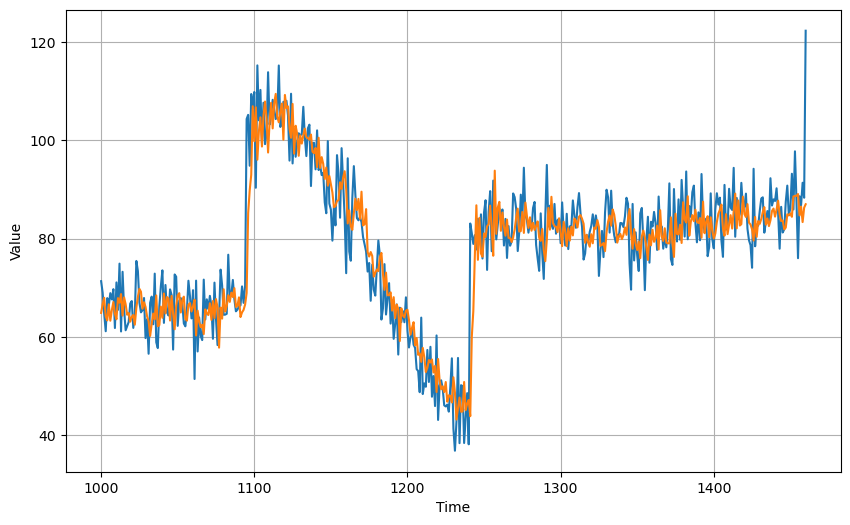

In [11]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model_baseline.predict(forecast_series[time:time + window_size][np.newaxis], verbose=0))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [12]:
# Compute the metrics
print(tf.keras.metrics.mse(x_valid, results).numpy())
print(tf.keras.metrics.mae(x_valid, results).numpy())

45.82713
5.006433


#### Tune the learning rate

You saw that the training went well with the initial learning rate that you chose (i.e. `1e-6`). However, you're not yet sure if it is the best setting for this particular model. It might seem inconsequential in this simple model but when you have more complex ones, spending some time to tune the learning rate can lead to better training results. You will see how to do that in this section.

First, you will build the same model architecture you just used.

In [10]:
# build the model
model_tune = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,)),
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

Next, you will declare a learning rate scheduler callback. This will allow you to dynamically set the learning rate based on the epoch number during training. As shown below, you will pass a lambda function to declare the value of the learning rate. It will start at `1e-8` at epoch 0 and is scaled by `10**(epoch / 20)` as the training goes on.

In [14]:
# set the learning training rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 ** (epoch / 20)
)

In [11]:
# default for SGD: learning_rate = 0.01
# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss="mse", optimizer=optimizer)

In [12]:
# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

NameError: name 'lr_schedule' is not defined

Next step is to plot the results of the training. You will visualize the loss at each value of the learning rate.

(1e-08, 0.001, 0.0, 300.0)

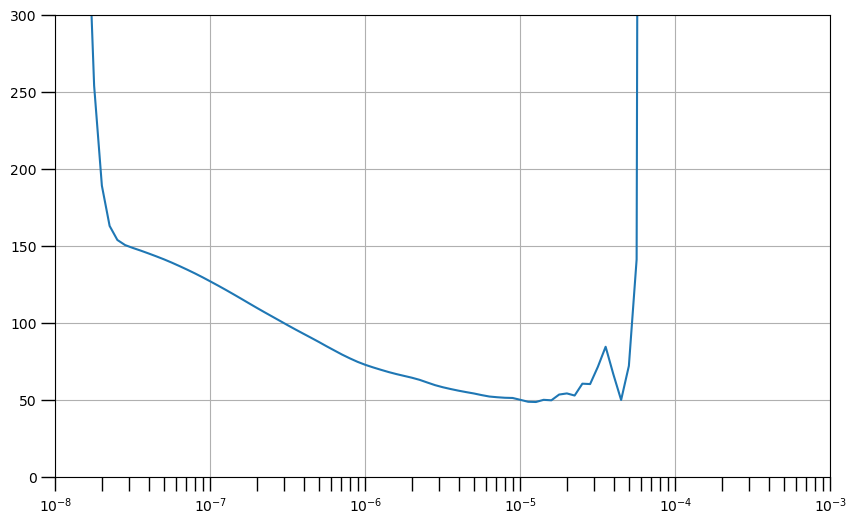

In [17]:
# define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# set the figure size
plt.figure(figsize=(10,6))

# set the grid
plt.grid(True)

# plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 300])

In [13]:
# Build the model
model_tune = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,)),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [14]:
# Set the optimizer with the tuned learning rate
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)

In [15]:
# Set the training parameters
model_tune.compile(loss="mse", optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 399.7253
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 79.0113
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 62.0541
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - loss: 50.6578
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 47.8227
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 46.0891
Epoch 7/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 32.1240

2024-12-18 17:00:01.754647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:01.786348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:01.813021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:01.836541: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:01.861572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:01.931162: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 44.8355
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 43.9538
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - loss: 43.1835
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - loss: 42.5982
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 42.0945
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 41.6848
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - loss: 41.3035
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 40.9093
Epoch 15/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24.8077

2024-12-18 17:00:01.986398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:02.020091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:02.053285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:02.085140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:02.116976: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:02.146766: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - loss: 40.5869
Epoch 16/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 40.2844
Epoch 17/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 40.0554
Epoch 18/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 39.6850
Epoch 19/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 39.4039
Epoch 20/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 39.1406
Epoch 21/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.1480

2024-12-18 17:00:02.205471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:02.253659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:02.285345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:02.325532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:02.360221: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:02.393407: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 38.7343
Epoch 22/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 38.5566
Epoch 23/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 38.4609
Epoch 24/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 38.6795
Epoch 25/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - loss: 38.2732
Epoch 26/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.7842

2024-12-18 17:00:02.428692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:02.465433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:02.547843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:02.582941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:02.617275: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 38.1275
Epoch 27/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 37.9840
Epoch 28/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 38.0635
Epoch 29/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - loss: 37.8236
Epoch 30/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 37.8067
Epoch 31/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - loss: 37.6092
Epoch 32/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.5988

2024-12-18 17:00:02.657708: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:02.697165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:02.733876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:02.766857: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:02.799861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:02.830991: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - loss: 37.6052
Epoch 33/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 37.6062
Epoch 34/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 37.4782
Epoch 35/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 37.5330
Epoch 36/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - loss: 37.2787
Epoch 37/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - loss: 37.2835
Epoch 38/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 37.1607
Epoch 39/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.4754

2024-12-18 17:00:02.863290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:02.896530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:02.927540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:02.957734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:02.986146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:03.017594: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - loss: 37.1718
Epoch 40/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37.3550
Epoch 41/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - loss: 37.2076
Epoch 42/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 37.1649
Epoch 43/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - loss: 37.0980
Epoch 44/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.9391

2024-12-18 17:00:03.080238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:03.154428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:03.183537: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:03.217784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:03.251587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 37.0224
Epoch 45/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 36.9608
Epoch 46/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 36.8877
Epoch 47/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - loss: 36.8402
Epoch 48/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 36.7635
Epoch 49/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 36.7254
Epoch 50/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - loss: 36.6631
Epoch 51/100


2024-12-18 17:00:03.286045: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:03.325053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:03.357021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:03.387963: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:03.422107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:03.452935: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - loss: 36.6469
Epoch 52/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - loss: 36.5752
Epoch 53/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 36.5446
Epoch 54/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - loss: 36.3994
Epoch 55/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 36.4839
Epoch 56/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 36.4232
Epoch 57/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - loss: 36.3614
Epoch 58/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.7814

2024-12-18 17:00:03.518566: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:03.549169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:03.579953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:03.611160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:03.641235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:03.671749: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 36.2258
Epoch 59/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 36.3028
Epoch 60/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 36.1794
Epoch 61/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 36.2452
Epoch 62/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.5977

2024-12-18 17:00:03.745720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:03.792183: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:03.887791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:03.929111: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 36.1399
Epoch 63/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 36.1797
Epoch 64/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - loss: 36.0440
Epoch 65/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - loss: 36.1144
Epoch 66/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 35.9736
Epoch 67/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - loss: 36.0302
Epoch 68/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.4633

2024-12-18 17:00:03.972134: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:04.015733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:04.050373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:04.084008: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:04.118053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:04.147657: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 35.9368
Epoch 69/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - loss: 36.0162
Epoch 70/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 35.8625
Epoch 71/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - loss: 35.9048
Epoch 72/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 35.8271
Epoch 73/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - loss: 35.8531
Epoch 74/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 35.7462
Epoch 75/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.6282

2024-12-18 17:00:04.178796: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:04.211987: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:04.242678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:04.270737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:04.303122: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:04.334372: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 35.8460
Epoch 76/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 35.7080
Epoch 77/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 35.8245
Epoch 78/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35.6058
Epoch 79/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - loss: 35.7695
Epoch 80/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 35.6001


2024-12-18 17:00:04.401335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:04.436447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:04.467926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:04.539081: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:04.569683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:04.600652: W tensorflow/core/framework/local_rendezvous.cc:404]

Epoch 81/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 35.7159
Epoch 82/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - loss: 35.5666
Epoch 83/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 35.6844
Epoch 84/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 35.5235
Epoch 85/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 35.6263
Epoch 86/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 35.4879
Epoch 87/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.4022

2024-12-18 17:00:04.634209: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:04.666043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:04.705937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:04.737781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:04.773793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:04.814711: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 35.5680
Epoch 88/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 35.4216
Epoch 89/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 35.5642
Epoch 90/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 35.4067
Epoch 91/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 35.4412
Epoch 92/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 35.3486
Epoch 93/100


2024-12-18 17:00:04.862380: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:04.912357: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:04.951777: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:04.986128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:05.020534: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:05.058459: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 35.4805
Epoch 94/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35.3085
Epoch 95/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 35.3737
Epoch 96/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 35.2711
Epoch 97/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 35.3465
Epoch 98/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20.6634

2024-12-18 17:00:05.097346: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:05.173864: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:05.208195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:05.249489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:05.285062: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 35.2136
Epoch 99/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 35.3222
Epoch 100/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - loss: 35.1715


2024-12-18 17:00:05.329620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:05.365858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 17:00:05.397566: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


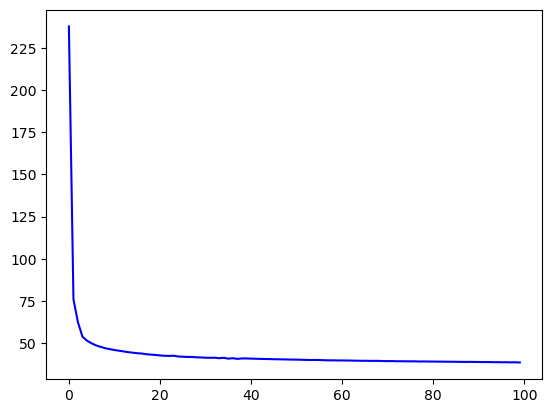

In [16]:
# Plot the loss
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

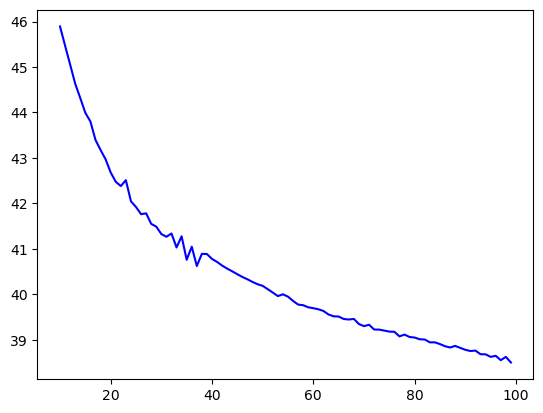

In [17]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

You can get the predictions again and overlay it on the validation set.

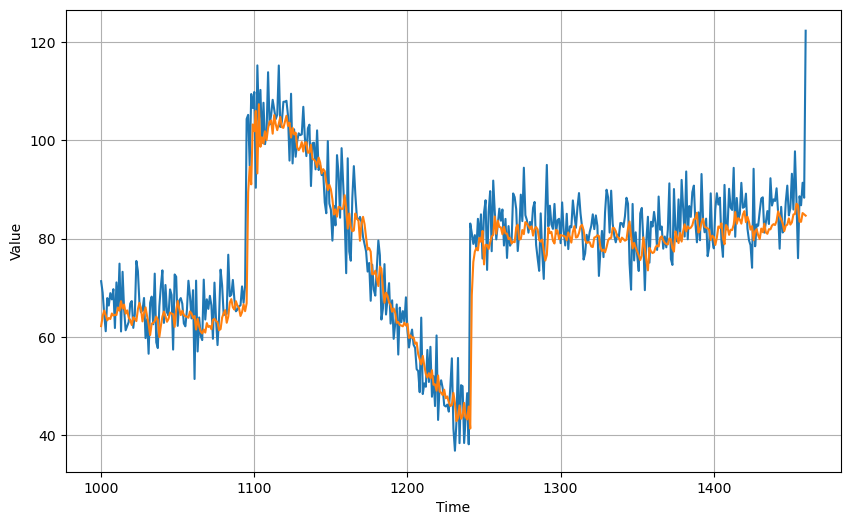

In [18]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model_tune.predict(forecast_series[time:time + window_size][np.newaxis], verbose=0))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

Finally, you can compute the metrics and you should arrive at similar figures compared to the baseline. If it is much worse, then the model might have overfitted and you can use techniques you know to avoid it (e.g. adding dropout).

In [19]:
print(tf.keras.metrics.mse(x_valid, results).numpy())
print(tf.keras.metrics.mae(x_valid, results).numpy())

45.12538
4.9125414


#### Wrap Up

This concludes the exercise on using a deep neural network for forecasting. Along the way, you did some hyperparameter tuning, particularly on the learning rate. You will be using this technique as well in the next labs. Next week, you will be using recurrent neural networks to build your forecasting model. See you there and keep it up!

But sequence data tends to work better with RNNs. So next week, you're going to look at training a model using RNNs and LSTMs on this data to see what happens.